Testing biological calibration of the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
strait_of_georgia = [54,64,68,79,62,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [20,21,23,26]
fraser_river_plume = [75,80,81]

### Puget Sound Data

In [7]:
# Extracting AMPS diatom data
amps_filename = "AMPS_OUT_7.nc"
amps_data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/" + amps_filename
amps_data = xr.open_dataset(str(amps_data_file), decode_cf=True) #[t, box, z]

amps_time = amps_data.t
amps_volume = amps_data.volume
diatoms_amps_tbz = amps_data.Lrg_Phyto_N * amps_volume #convert to mg N 
diatoms_amps_tb = diatoms_amps_tbz.sum(axis=2)
diatoms_amps_t = diatoms_amps_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

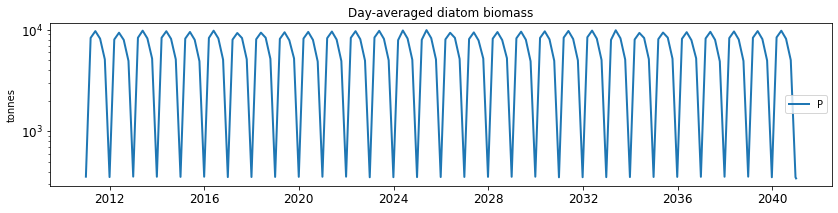

In [10]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(amps_time, diatoms_amps_t, linewidth = 2) #semilogy
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
ax.legend(('Puget Sound Atlantis diatoms'), loc='best');

## Phytoplankton

In [3]:
filename = "v6718_365_20241105_fisheriesOFF"
# One year of daily output, after the 15-year model burn-in. Year of output starts at 2007.

In [4]:
# Extracting SSAM diatom data
diatom_filename = "v6718_365_20241105_fisheriesOFF"
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/" + diatom_filename + "/outputSalishSea.nc"
data = xr.open_dataset(str(data_file), decode_cf=True) #[t, box, z]

ssam_time = data.t
ssam_volume = data.volume
diatoms_SSAM_tbz = data.Diatom_N * ssam_volume #convert to mg N 
diatoms_SSAM_tb = diatoms_SSAM_tbz.sum(axis=2)
diatoms_SSAM_t = diatoms_SSAM_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

In [8]:
# SalishSeaCast daily averaged diatom data for 30 days in 2007
ssc_data = xr.open_dataset('/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc')
mesh = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

ssc_volume = (mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
diatoms_SSC_tzyx = ssc_data.diatoms # [t,z,y,x]
diatoms_SSC_tzyx = diatoms_SSC_tzyx * ssc_volume # convert from mmol m-3 to mmol
# Convert mmol N * 0.001 mol N * 14.0067 g/mol * 0.000001 tonnes 
diatoms_SSC_tzy = diatoms_SSC_tzyx.sum(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.sum(axis=2)
diatoms_SSC_t = diatoms_SSC_tz.sum(axis=1) * (0.001*14.0067*0.000001) #convert to tonnes

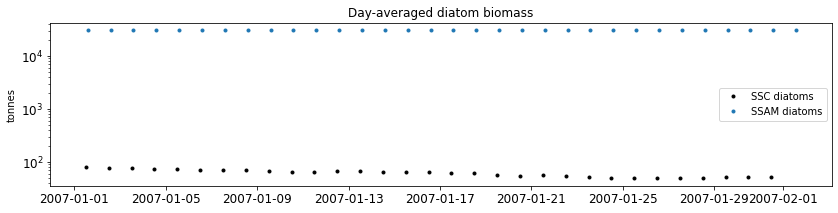

In [10]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2) #semilogy
ax.semilogy(ssam_time[5:37], diatoms_SSAM_t[5:37],'.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms'), loc='best');

In [12]:
picos_SSAM_tbz = data.PicoPhytopl_N * ssam_volume #convert to mg N 
picos_SSAM_tb = picos_SSAM_tbz.sum(axis=2)
picos_SSAM_t = picos_SSAM_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

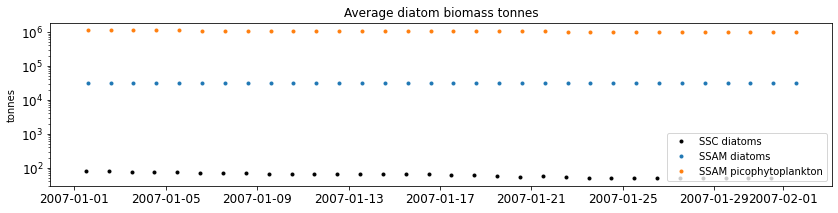

In [14]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2)
ax.semilogy(ssam_time[5:37], diatoms_SSAM_t[5:37],'.', linewidth = 2)
ax.semilogy(ssam_time[5:37], picos_SSAM_t[5:37], '.', linewidth = 2)
ax.set_title('Average diatom biomass tonnes', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms', 'SSAM picophytoplankton'), loc='best');

Atlantis diatom biomass is >2 orders of magnitude that for Salish Sea Cast in the same model time period (Jan 2007). SSAM picophytoplankton is an order of magnitude higher than for SSAM diatoms. 

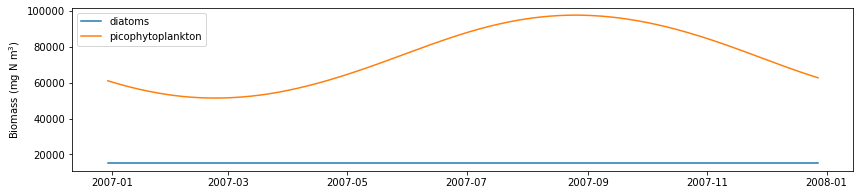

In [15]:
bio_group = groups.phytoplankton
location = strait_of_georgia
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'_N'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_ylabel('Biomass (mg N m$^3$)');

In [16]:
# Checking the same plots in terms of nitrogen
diatoms_SSAM_N = diatoms_SSAM_tb.sum(axis=1) #mg N
diatoms_SSC_N = diatoms_SSC_tz.sum(axis=1) * 14.006747 #mg N


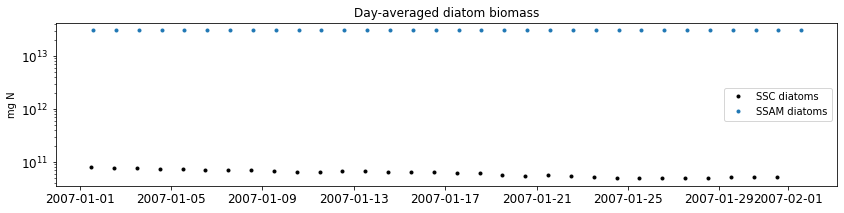

In [17]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_N, 'k.', linewidth = 2) #semilogy
ax.semilogy(ssam_time[5:37], diatoms_SSAM_N[5:37],'.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms'), loc='best');

In [19]:
def plot_pelagic_depth(group, location):

    fig = plt.figure(figsize=(18, 27), facecolor='white')
    gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1]) 

    depth = [250, 100, 50, 25, 0]

    for species in group:

        names = []

        bio_index = (list(group).index(species))

        if bio_index < 4:
            position = 0, bio_index
        elif bio_index > 8: 
            position = 2, bio_index-8
        else :
            position = 1, bio_index-4

        ax = fig.add_subplot(gs[position])
        ax.set_ylim(100, 0)  # decreasing depth
            
        pelagic_oiled = data.variables[group[species] + '_N'][:,location,2:7]
        p_oiled = pelagic_oiled.sum(axis=0)
        p_oiled = p_oiled.sum(axis=0)
        ax.plot(p_oiled, depth, linewidth = 2) #color=line_colour, linestyle=line_type,
        ax.set_title(species);
        ax.set_ylabel('depth, m')
        ax.set_xlabel('mg N m$^{-3}$')
    ax.legend(str(filename), bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', )

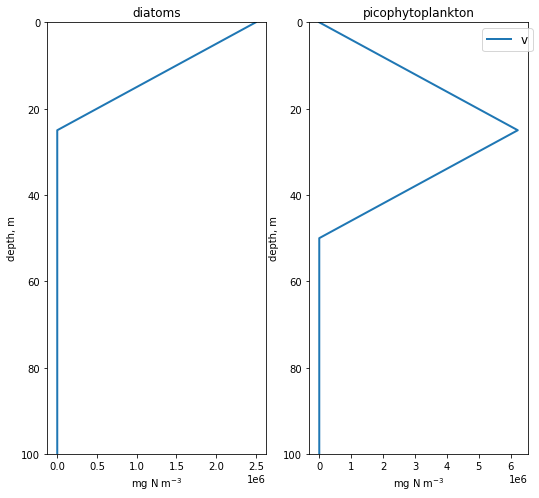

In [20]:
plot_pelagic_depth(groups.phytoplankton, groups.haro_boundary)

## Invertebrates

In [6]:
# Reading in Atlantis map

shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

In [7]:
filename = "v6718_365_20241105_fisheriesOFF"
# One year of daily output, after the 15-year model burn-in. Year of output starts at 2007.


In [8]:
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/" + filename + "/outputSalishSea.nc"
data = xr.open_dataset(str(data_file), decode_cf=True) #[t, box, z


In [17]:
time = data.t

## Wild salmon

In [64]:
def map_numbers(variable, timestamp):
    variable_name = variable + '_Nums'
    plot_data = data.variables[variable_name][timestamp,:,:]
    #plot_data = plot_data.sum(axis=0)
    data_df['plot_data'] = plot_data.sum(axis=1)
    land_df = data_df.loc[land_boxes]
    ps_df = data_df.loc[puget_sound_main]
    
    fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.95) 
    ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white');

In [47]:
time = np.ma.filled(data.variables['t'], np.nan)

In [67]:
def map_inv_biomass(variable, timestamp, v_min=None, v_max=None):
    plot_data = (data.variables[variable + '_StructN'][timestamp,:,:] + data.variables[variable + '_ResN'][timestamp,:,:] * data.variables[variable + '_Nums'][timestamp,:,:])*20*5.7*(3.65/2.65)/1000000
    #plot_data = plot_data.sum(axis=0)
    data_df['plot_data'] = plot_data.sum(axis=1) 
    land_df = data_df.loc[land_boxes]

    fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.95) 
    ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), vmin=v_min, vmax=v_max, #cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable +' wet weight biomass (tonnes)'
    },)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white')
    ax.set_title(variable +' at time '+ str(time[timestamp]), fontsize = 12);

In [68]:
def map_biomass(variable, timestamp, v_min=None, v_max=None):
    plot_data = data.variables[variable + '_N'][timestamp,:,:] #*20*5.7*(3.65/2.65)/1000000
    #plot_data = plot_data.sum(axis=0)
    data_df['plot_data'] = plot_data.sum(axis=1) 
    land_df = data_df.loc[land_boxes]

    fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.95) 
    ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), vmin=v_min, vmax=v_max, #cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable #+' wet weight biomass (tonnes)'
    },)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white')
    ax.set_title(variable +' at time '+ str(time[timestamp]), fontsize = 12);

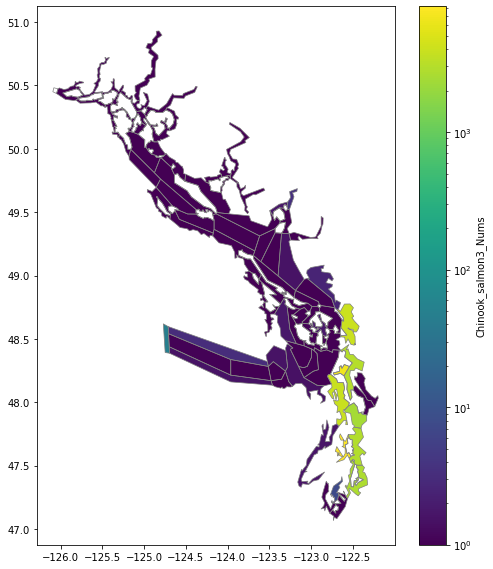

In [65]:
map_numbers('Chinook_salmon3',90)

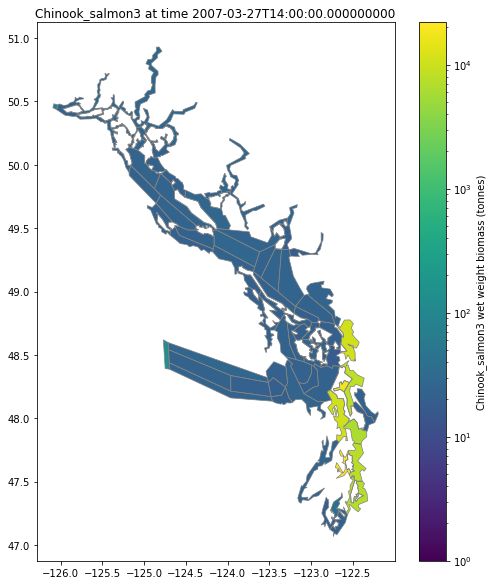

In [74]:
map_inv_biomass('Chinook_salmon3', 90)

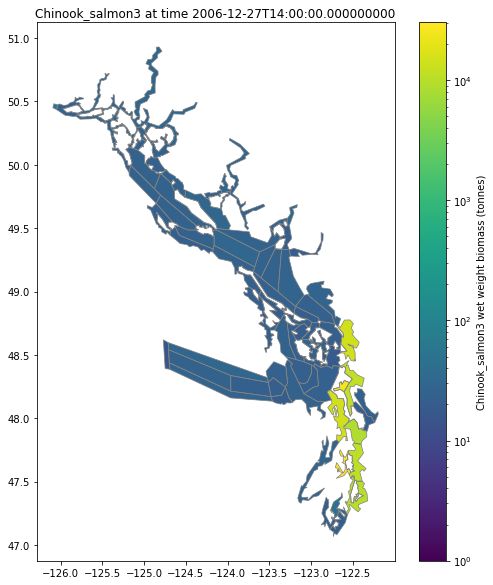

In [75]:
map_inv_biomass('Chinook_salmon3', 0)

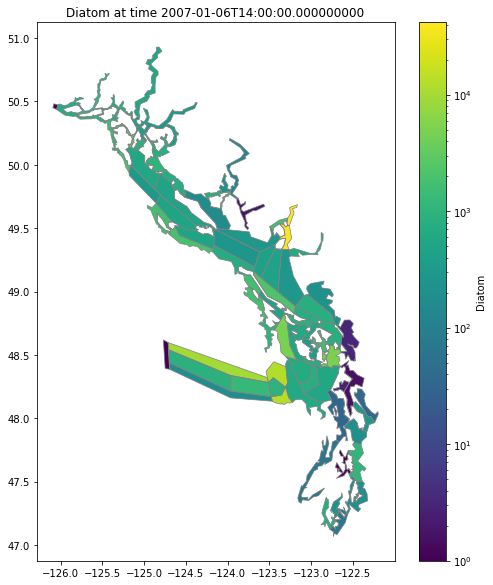

In [69]:
map_biomass('Diatom', 10)

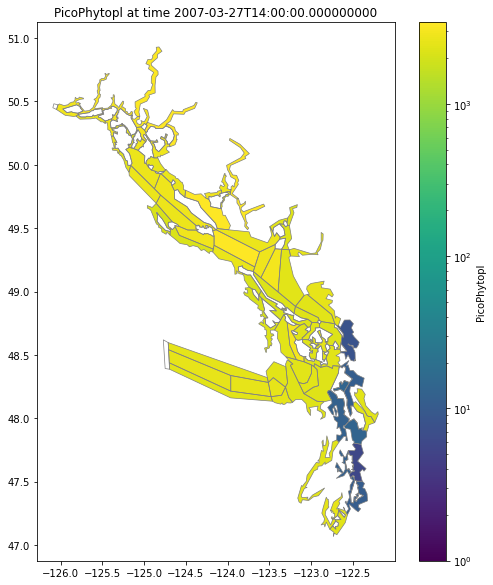

In [72]:
map_biomass('PicoPhytopl', 90)

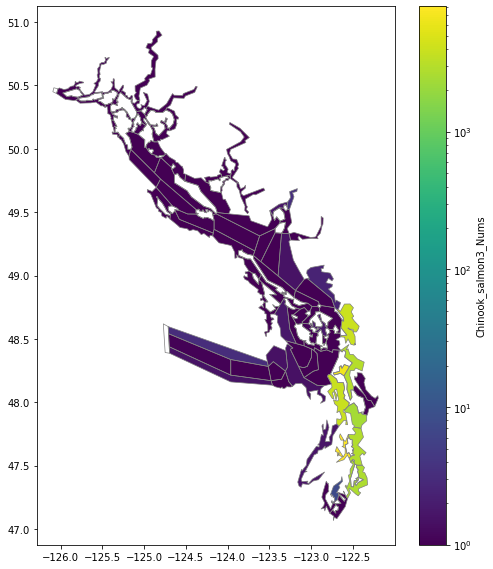

In [27]:
variable_name = 'Chinook_salmon3_Nums'
plot_data = data.variables[variable_name][data.t.size-1,:,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white');


In [ ]:
def map_biomass(variable, timestamp, v_min=None, v_max=None):
    plot_data = (data.variables[variable + '_StructN'][timestamp,:,:] + data.variables[variable + '_ResN'][timestamp,:,:] * data.variables[variable + '_Nums'][timestamp,:,:])*20*5.7*(3.65/2.65)/1000000
    #plot_data = plot_data.sum(axis=0)
    data_df['plot_data'] = plot_data.sum(axis=1) 
    land_df = data_df.loc[land_boxes]

    fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.95) 
    ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), vmin=v_min, vmax=v_max, #cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable +' wet weight biomass (tonnes)'
    },)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white')
    ax.set_title(variable +' at time '+ str(time[timestamp]), fontsize = 12);

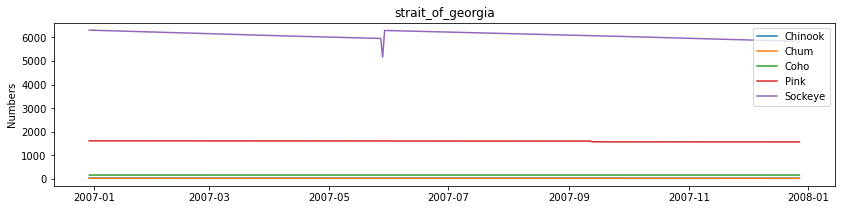

In [28]:
bio_group = groups.wild_salmon
location = strait_of_georgia
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('strait_of_georgia', fontsize = 12)
ax.set_ylabel('Numbers');

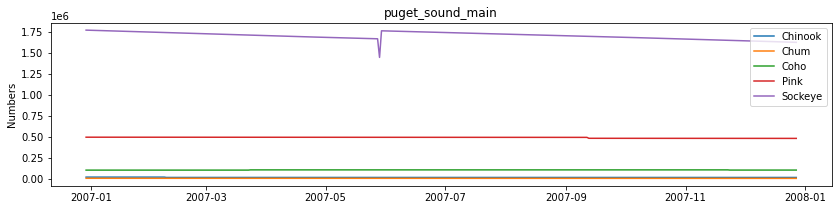

In [35]:
bio_group = groups.wild_salmon
location = puget_sound_main
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('puget_sound_main', fontsize = 12)
ax.set_ylabel('Numbers');

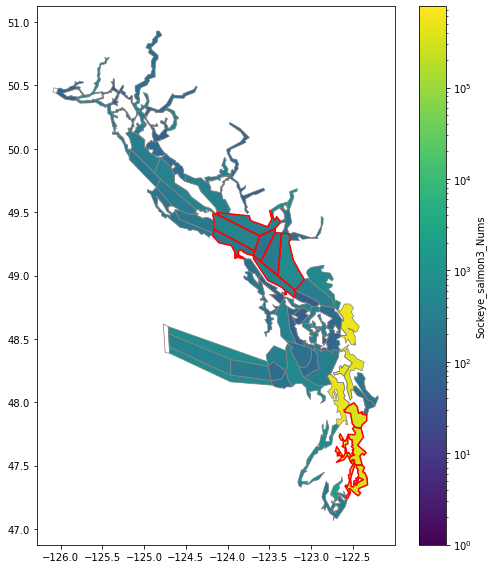

In [32]:
variable_name = 'Sockeye_salmon3_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[sog_center]
ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()),#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');


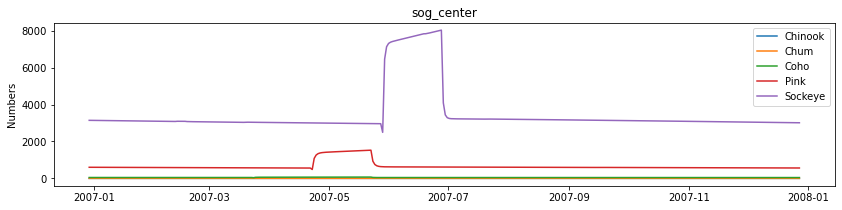

In [29]:
bio_group = groups.wild_salmon
location = sog_center
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'1_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('sog_center', fontsize = 12)
ax.set_ylabel('Numbers');

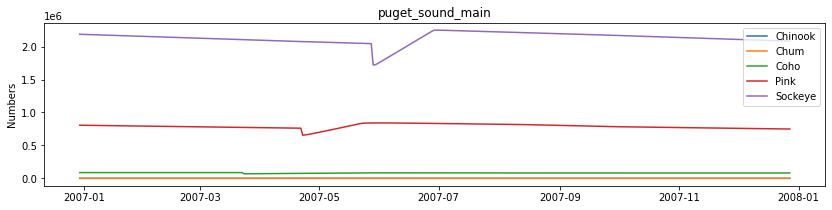

In [30]:
bio_group = groups.wild_salmon
location = puget_sound_main
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'1_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('puget_sound_main', fontsize = 12)
ax.set_ylabel('Numbers');

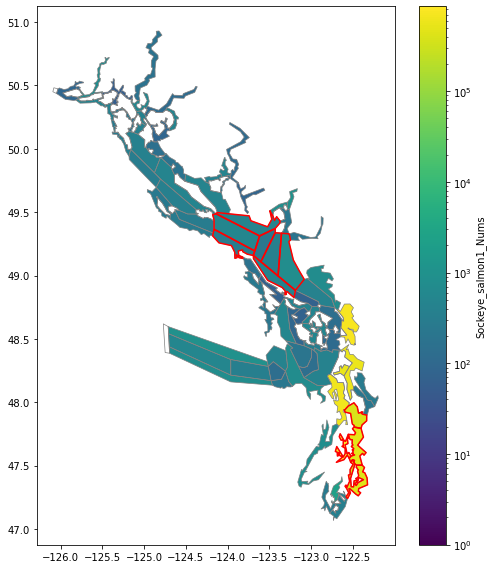

In [33]:
variable_name = 'Sockeye_salmon1_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[sog_center]
ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()),#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

## Wild + hatchery salmon

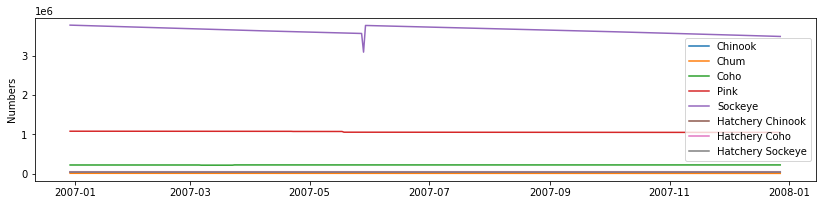

In [7]:
bio_group = groups.salmon
location = groups.salish_sea
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
#ax.set_title('strait_of_georgia', fontsize = 12)
ax.set_ylabel('Numbers');

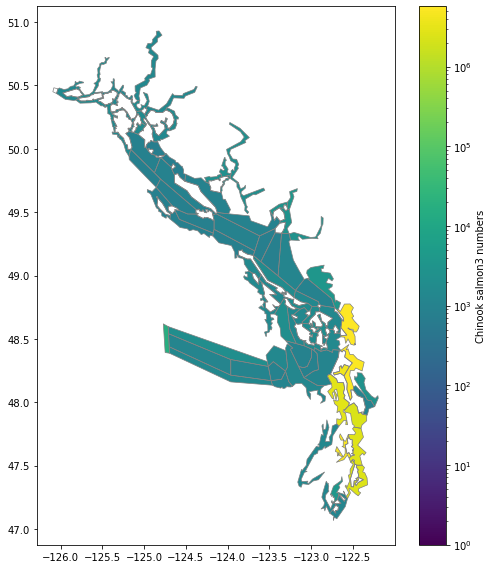

In [10]:
# Wild salmon
plot_data = data.variables['Chinook_salmon3_Nums'] + data.variables[variable2]
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
#strait_df = data_df.loc[strait_of_georgia]
#ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': 'Chinook salmon3 numbers'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#strait_df.boundary.plot(ax=ax, color='red');
#ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

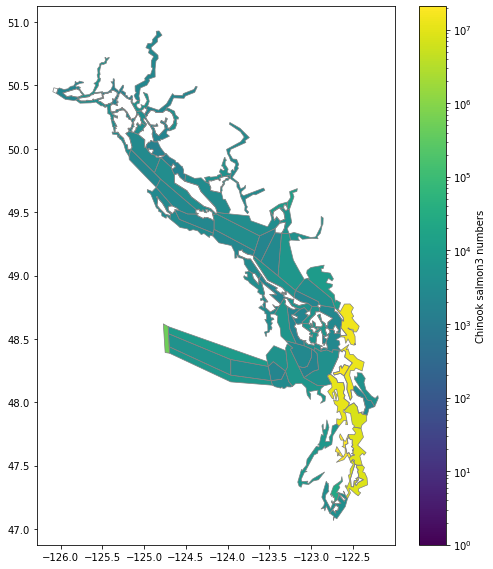

In [11]:
variable1 = 'Coho_salmon3_Nums'
variable2 = 'Hatchery_Coho_salmon3_Nums'
plot_data = data.variables[variable1] + data.variables[variable2]
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
#strait_df = data_df.loc[strait_of_georgia]
#ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': 'Chinook salmon3 numbers'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#strait_df.boundary.plot(ax=ax, color='red');
#ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

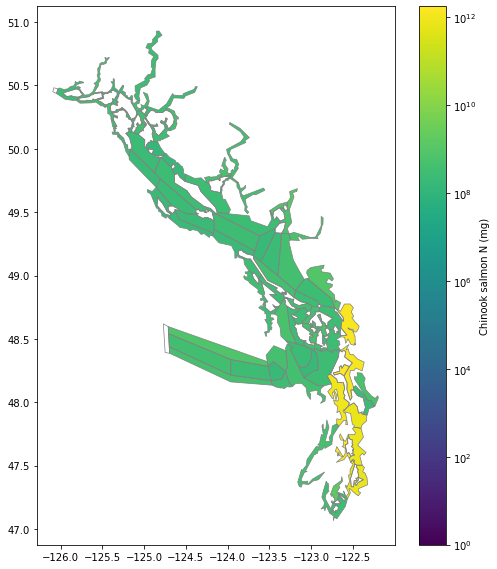

In [14]:
variable1 = 'Chinook_salmon_N'
variable2 = 'Hatchery_Chinook_salmon_N'
plot_data = (data.variables[variable1] + data.variables[variable2]) * data.volume
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
#strait_df = data_df.loc[strait_of_georgia]
#ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': 'Chinook salmon N (mg)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#strait_df.boundary.plot(ax=ax, color='red');
#ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

Calculate weight at age in wet weight (tons) to compare with Puget Sound data and with other data on these species in the literature. PSA team uses the following conversations 20  5.7 (redfield ratio) (3.65/2.65)/1000000

In [ ]:
#Hatchery Salmon 
# *20*5.7*(3.65/2.65)/1000000

variable1 = 'Chinook_salmon_N'
variable2 = 'Hatchery_Chinook_salmon_N'
plot_data = (data.variables[variable1] + data.variables[variable2]) * data.volume
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
#strait_df = data_df.loc[strait_of_georgia]
#ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': 'Chinook salmon N (mg)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#strait_df.boundary.plot(ax=ax, color='red');
#ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

In [20]:
def compare_cohorts(bio_group, boxes):

    for species in bio_group:

        fig, ax = plt.subplots(figsize = (14,4), sharex='all')

        numCohorts = groups.cohorts[bio_group[species]]

        for cohort in range (1, numCohorts+1):

            new_species = bio_group[species] + str(cohort)
        
            o_numbers_tbl = data.variables[new_species + '_Nums'][:,boxes,:]
            o_structuralN_tbl = data.variables[new_species +'_StructN'][:,boxes,:]
            o_reservedN_tbl = data.variables[new_species +'_ResN'][:,boxes,:]

            o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl * o_numbers_tbl) *20*5.7*(3.65/2.65)/1000000
            o_weightatage_tb = o_weightatage_tbl.sum(axis=2)
            o_weightatage_t = o_weightatage_tb.sum(axis=1)

            ax.plot(time, o_weightatage_t, linewidth = 2)
    
        ax.set_title('Biomass of ' + str(bio_group[species]), fontsize = 12)
        ax.set_ylabel('Wet weight (tonnes)', fontsize = 12)
        ax.tick_params(labelsize=11)
        ax.legend(['cohort 1','cohort 2','cohort 3','cohort 4','cohort 5','cohort 6','cohort 7','cohort 8','cohort 9','cohort 10',]) #loc='center left'

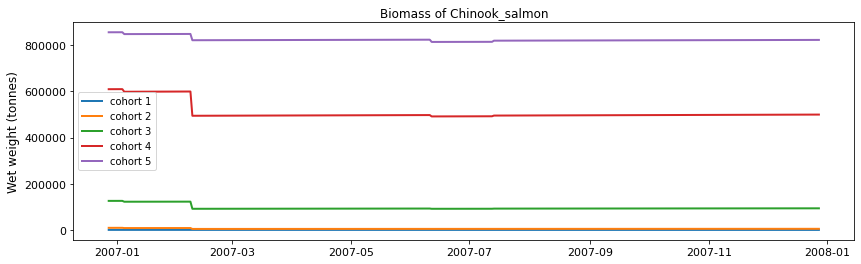

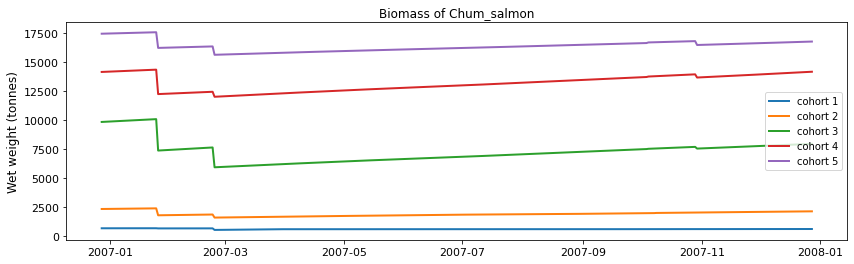

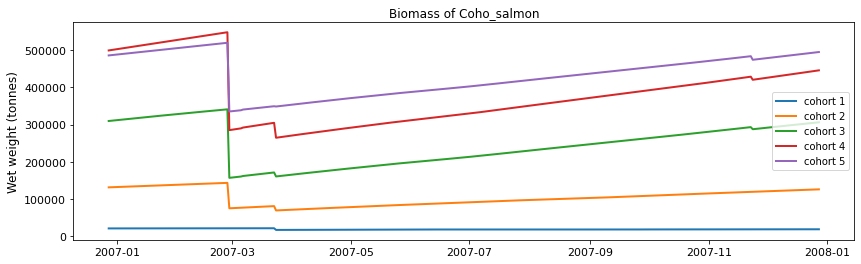

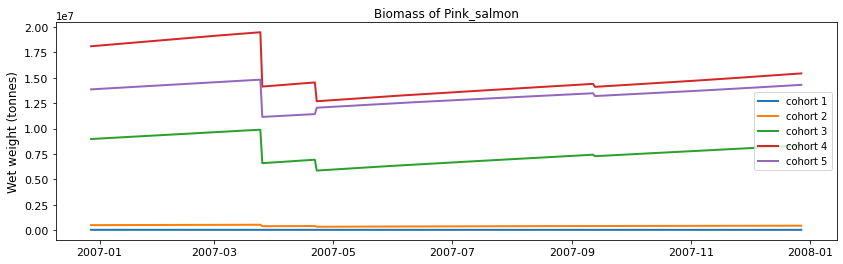

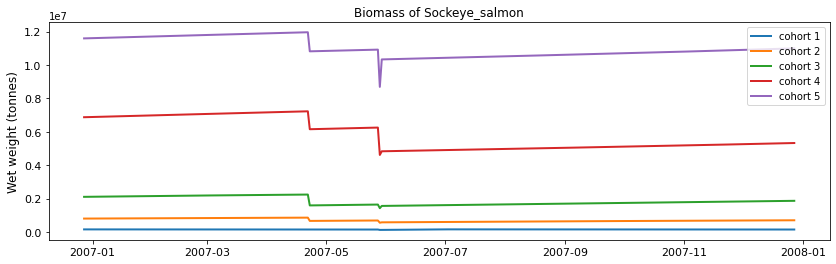

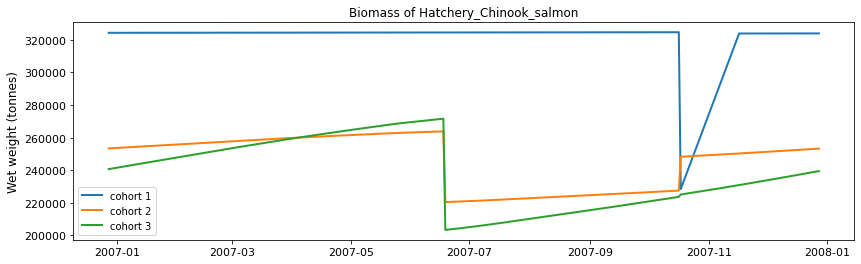

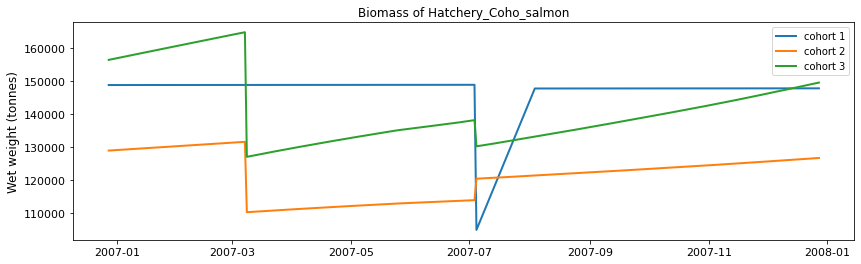

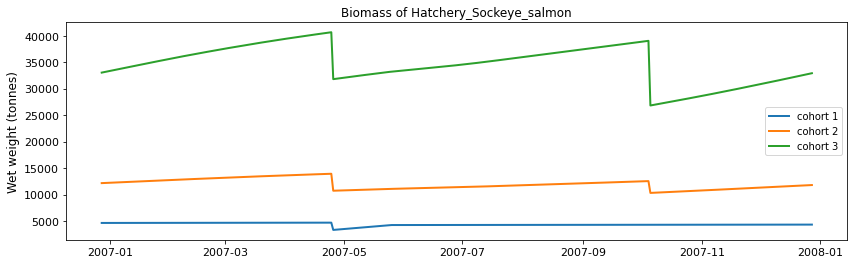

In [19]:
compare_cohorts(groups.salmon, groups.salish_sea)

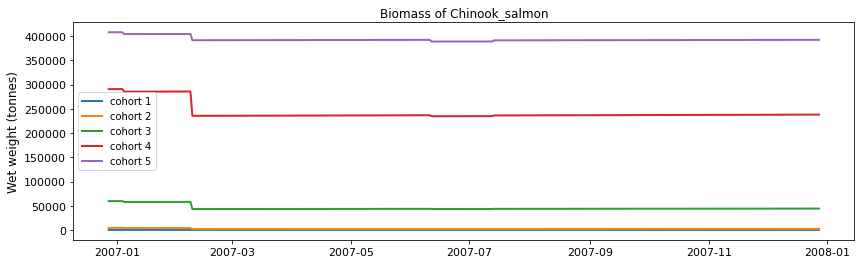

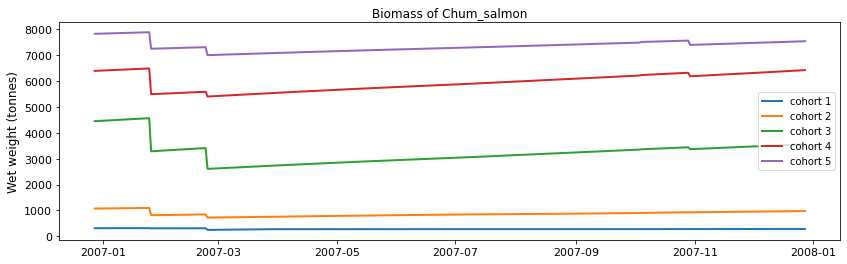

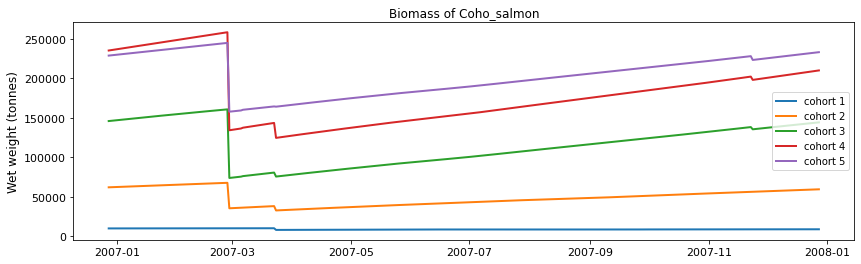

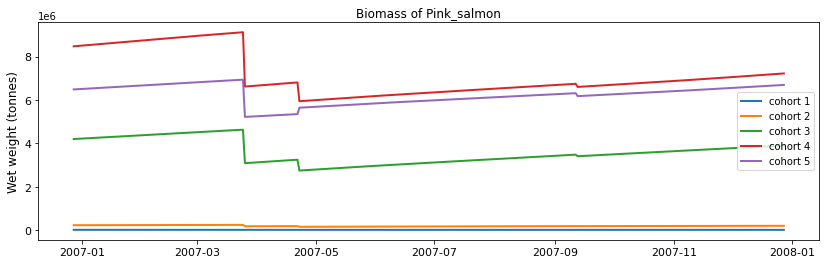

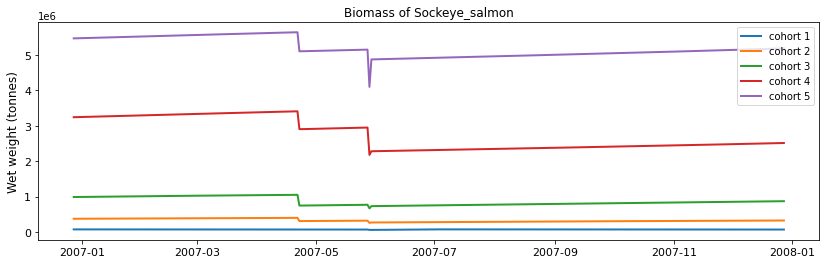

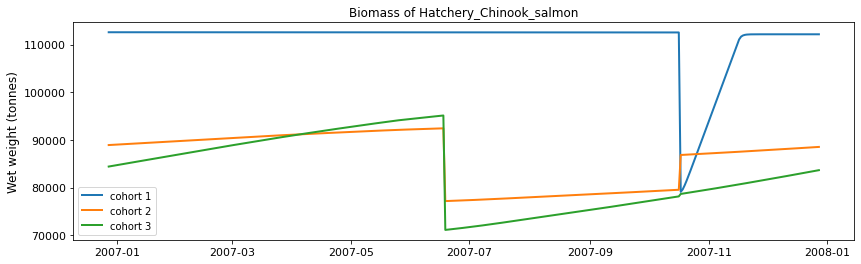

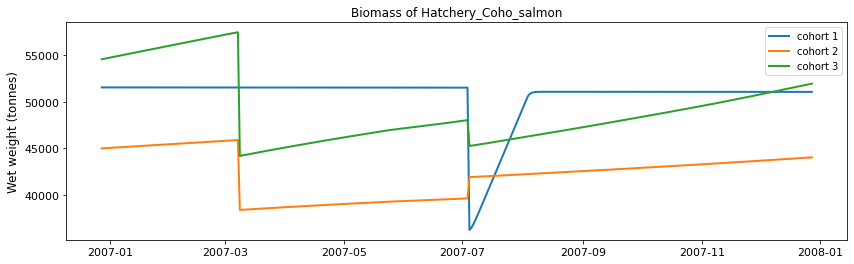

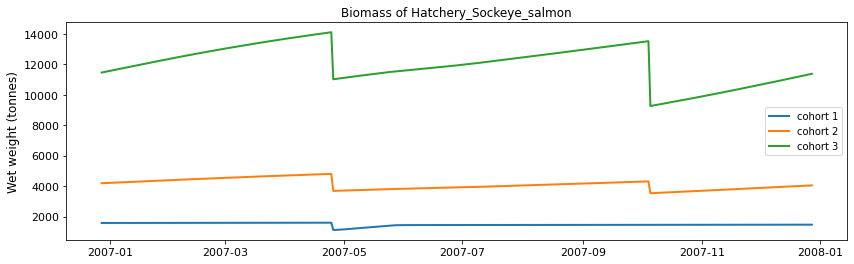

In [22]:
compare_cohorts(groups.salmon, groups.puget_sound_main)

In [ ]:
#Hatchery Salmon 
# *20*5.7*(3.65/2.65)/1000000

variable1 = 'Chinook_salmon_N
plot_data = (data.variables[variable1] + data.variables[variable2]) * data.volume
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
#strait_df = data_df.loc[strait_of_georgia]
#ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': 'Chinook salmon N (mg)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#strait_df.boundary.plot(ax=ax, color='red');
#ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');

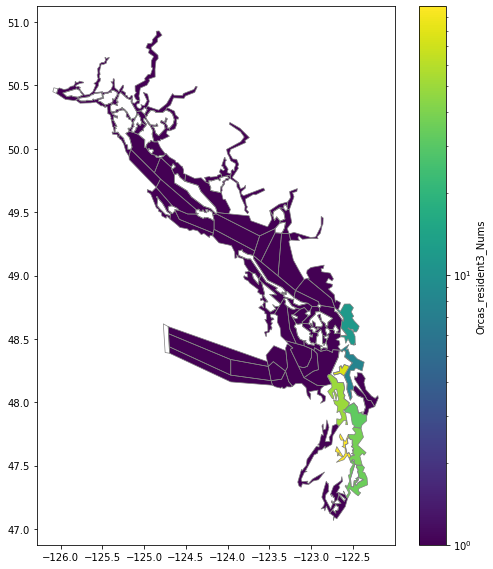

In [63]:
map_numbers('Orcas_resident3',10)